In [1]:
import os 
import tarfile
from six.moves import urllib

In [2]:
DOWNLOAD_ROOT="https://raw.githubusercontent.com/ageron/handson-ml/master/"
FILE_PATH="datasets/housing"
HOUSING_URL = DOWNLOAD_ROOT + FILE_PATH + "/housing.tgz"

In [3]:
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=FILE_PATH): 
    if not os.path.isdir(housing_path): 
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz") 
    urllib.request.urlretrieve(housing_url, tgz_path) 
    housing_tgz = tarfile.open(tgz_path) 
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [4]:
import pandas as pd 
def load_housing_data(housing_path=FILE_PATH): 
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [5]:
fetch_housing_data()
housing=load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [6]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [7]:
housing.isnull().any()

longitude             False
latitude              False
housing_median_age    False
total_rooms           False
total_bedrooms         True
population            False
households            False
median_income         False
median_house_value    False
ocean_proximity       False
dtype: bool

In [8]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [9]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

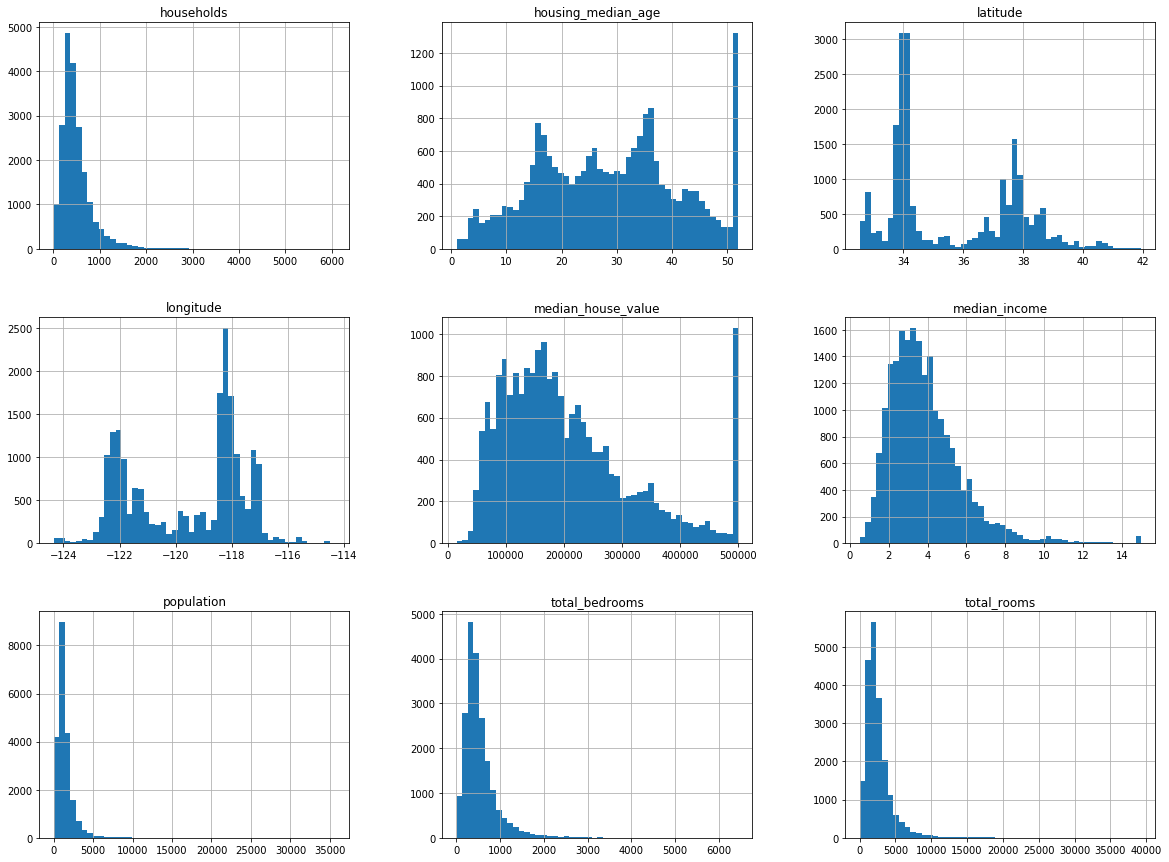

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt 
housing.hist(bins=50, figsize=(20,15))
plt.show()

### split by random ordered data

In [11]:
import numpy as np
def split_train_test(data, test_ratio): 
    np.random.seed(42)
    shuffled_indices = np.random.permutation(len(data)) 
    test_set_size = int(len(data) * test_ratio) 
    test_indices = shuffled_indices[:test_set_size] 
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [12]:
# train_set, test_set = split_train_test(housing, 0.2)
# print(len(train_set), "train +", len(test_set), "test")

### split by hash

In [13]:
import hashlib 
def test_set_check(identifier, test_ratio, hash):
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio

In [12]:
def split_train_test_by_id(data, test_ratio, id_column, hash=hashlib.md5): 
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio, hash))
    return data.loc[~in_test_set], data.loc[in_test_set]

NameError: name 'hashlib' is not defined

In [15]:
# housing_with_id = housing.reset_index() # adds an `index` column
# train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

### split by sklearn

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

### split by income strata

divide data into salary greater 5*(ceil(income / income_median)) or not

In [15]:
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)

Get train and test based income strata by using StratifiedShuffleSplit

In [16]:
from sklearn.model_selection import StratifiedShuffleSplit
#define funcion
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42) 
# get the sets by apply the function
for train_index, test_index in split.split(housing, housing["income_cat"]): 
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [17]:
print(housing["income_cat"].value_counts()/len(housing),
      strat_train_set["income_cat"].value_counts()/len(strat_train_set),
      strat_test_set["income_cat"].value_counts()/len(strat_test_set))

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64 3.0    0.350594
2.0    0.318859
4.0    0.176296
5.0    0.114402
1.0    0.039850
Name: income_cat, dtype: float64 3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114583
1.0    0.039729
Name: income_cat, dtype: float64


Drop the income_cat we create before

In [18]:
for set in (strat_train_set, strat_test_set):
    set.drop(["income_cat"], axis=1, inplace=True)

## Discover and Visualize the Data to Gain Insights

In [19]:
housing=strat_test_set.copy()

## Visualizing Geographical Data

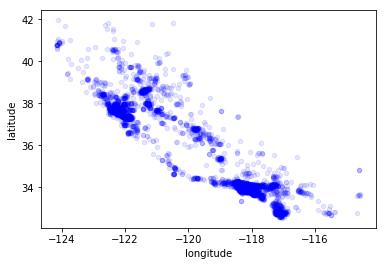

In [20]:
housing.plot(kind="scatter", x="longitude", y="latitude",color="blue",alpha=0.1)

####  s imply size, c imply colors (greater than one)  cmap means color map

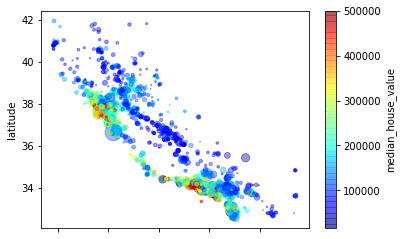

In [21]:
housing.plot(kind="scatter", x="longitude", y="latitude",
             alpha=0.4,s=housing["population"]/100,
             c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True)

Compute correlation, the column in [] be compute as target  

In [22]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.691831
total_rooms           0.131435
housing_median_age    0.071357
households            0.071242
total_bedrooms        0.057568
population           -0.016033
longitude            -0.039987
latitude             -0.150124
Name: median_house_value, dtype: float64

In [23]:
housing.columns.values.tolist()

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'median_house_value',
 'ocean_proximity']

### plot correlation plot for particular columns

C:\Software\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: 'pandas.tools.plotting.scatter_matrix' is deprecated, import 'pandas.plotting.scatter_matrix' instead.
  This is separate from the ipykernel package so we can avoid doing imports until


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000255F46B5358>,
      dtype=object)

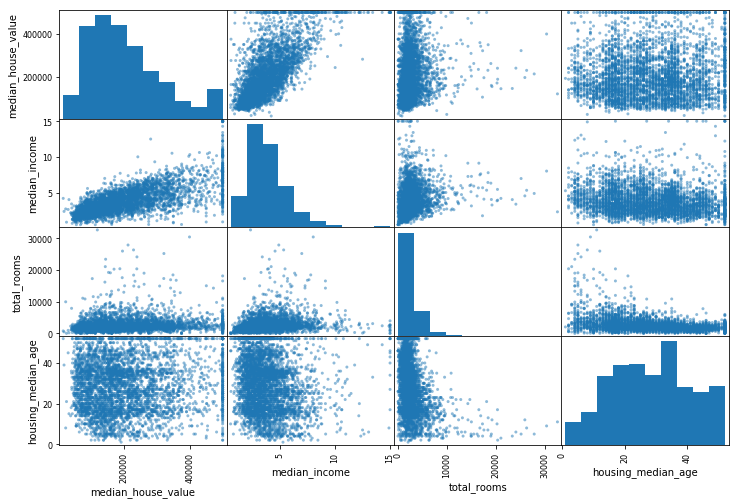

In [24]:
from pandas.tools.plotting import scatter_matrix
attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))


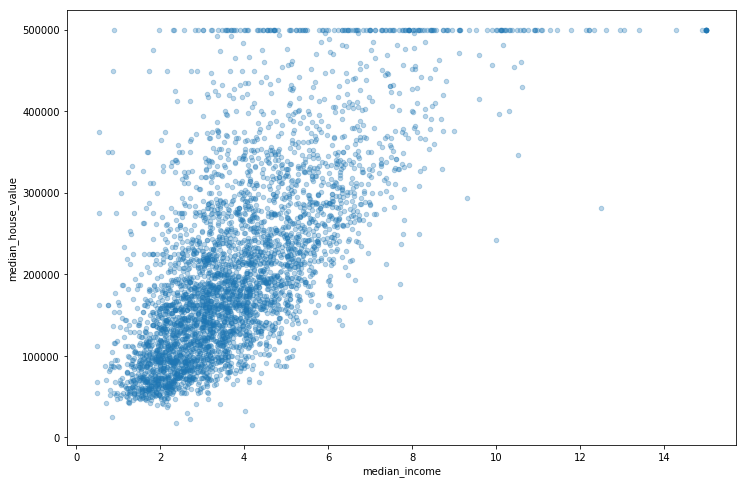

In [25]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.3, figsize=(12, 8))

### attribute combinations

In [26]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"] 
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

In [27]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.691831
rooms_per_household         0.192575
total_rooms                 0.131435
housing_median_age          0.071357
households                  0.071242
total_bedrooms              0.057568
population                 -0.016033
longitude                  -0.039987
population_per_household   -0.135142
latitude                   -0.150124
bedrooms_per_room          -0.240362
Name: median_house_value, dtype: float64

 The new bedrooms_per_room attribute is much more correlated with the median house value than the total number of rooms or bedrooms. 

### seprete decribe and target

In [28]:
housing = strat_train_set.drop("median_house_value", axis=1) 
housing_labels = strat_train_set["median_house_value"].copy()

### deal with missing value

In [29]:
# housing.dropna(subset=["total_bedrooms"]) # drop whole column
# housing.drop("total_bedrooms", axis=1) # drop instances contains null
# median = housing["total_bedrooms"].median()
# housing["total_bedrooms"].fillna(median) # fill null with median

####  Fill missing with skilearn

In [30]:
from sklearn.preprocessing import Imputer 
imputer = Imputer(strategy="median")

only contains numeric value's data

In [31]:
housing_num = housing.drop("ocean_proximity", axis=1)

In [32]:
imputer.fit(housing_num)
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

same as

In [33]:
#housing_num.median().values

In [34]:
X = imputer.transform(housing_num)

imputer.fit() + imputer.transform() equals imputer.fit_transform()

#### transform output into dataframe

In [35]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns)

In [36]:
housing_tr.isnull().any()

longitude             False
latitude              False
housing_median_age    False
total_rooms           False
total_bedrooms        False
population            False
households            False
median_income         False
dtype: bool

### encode categorical features

encode catehprical features into integer first

In [37]:
from sklearn.preprocessing import LabelEncoder 
encoder = LabelEncoder()
housing_cat = housing["ocean_proximity"]
housing_cat_encoded = encoder.fit_transform(housing_cat)
housing_cat_encoded

array([0, 0, 4, ..., 1, 0, 3], dtype=int64)

In [38]:
encoder.classes_

array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
      dtype=object)

the function above not useful if the level without order character,  one-hot encoding is a great way to do so

### One-hot encoding

In [39]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder() 
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1,1))
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

### Way to convert categorical to one-hot directly

using LabelBinarizer

In [40]:
from sklearn.preprocessing import LabelBinarizer 
encoder = LabelBinarizer() 
housing_cat_1hot = encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       ...,
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0]])

modify self function

In [177]:
rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6
class CombinedAttributesAdder(BaseEstimator, TransformerMixin): 
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs 
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None): 
        return self # nothing else to do
    def transform(self, X, y=None): 
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix] 
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

The file under the same path , named conbination_self.py

In [178]:
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False) 
housing_extra_attribs = attr_adder.transform(housing.values)

In [43]:
pd.DataFrame(housing_extra_attribs).head()

,0,1,2,3,4,5,6,7,8,9,10
0,-121.89,37.29,38,1568,351,710,339,2.7042,<1H OCEAN,4.62537,2.0944
1,-121.93,37.05,14,679,108,306,113,6.4214,<1H OCEAN,6.00885,2.70796
2,-117.2,32.77,31,1952,471,936,462,2.8621,NEAR OCEAN,4.22511,2.02597
3,-119.61,36.31,25,1847,371,1460,353,1.8839,INLAND,5.23229,4.13598
4,-118.59,34.23,17,6592,1525,4459,1463,3.0347,<1H OCEAN,4.50581,3.04785


### Transformation Pipeline

In [44]:
list(housing_num) 

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income']

In [45]:
from sklearn.base import BaseEstimator, TransformerMixin 
class DataFrameSelector(BaseEstimator, TransformerMixin): 
    def __init__(self, attribute_names): 
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [206]:
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline 
from sklearn.preprocessing import StandardScaler

def prepare_data(data):
    data=data

    num_attribs = list(housing_num) 
    cat_attribs = ["ocean_proximity"]

    # cat_pipeline = Pipeline([ 
    #      # select categorical
    #     ('selector', DataFrameSelector(cat_attribs)),
    #     # categorical to on-hot encoding
    #     #('label_binarizer', LabelBinarizer()),
    #     #("To_integer",LabelEncoder()),
    #     ('label_binarizer',OneHotEncoder(sparse=False)),
    # ])


    num_pipeline = Pipeline([
        ("Select_feature",DataFrameSelector(num_attribs)), #select only numeric 
        ('imputer', Imputer(strategy="median")),  # fill median value into null
        ('attribs_adder',CombinedAttributesAdder()),   # feature combination
        ('std_scaler', StandardScaler()), # normilazation
    ])
    
#     if len(data)>100:
#         LabelBinarizer().fit(data["ocean_proximity"])
    return np.concatenate((num_pipeline.fit_transform(data),LabelBinarizer().fit_transform(data["ocean_proximity"])),axis=1)
    #return num_pipeline.fit_transform(data)
    #return LabelBinarizer().transform(data["ocean_proximity"])
    # join two pieline together and run parallel
    # full_pipeline = FeatureUnion(transformer_list=[ 
    #     ("num_pipeline", num_pipeline), 
    #     ("cat_pipeline", cat_pipeline),
    # ])

    #housing_num_tr = num_pipeline.fit_transform(housing_num)

new version:

try:
    from sklearn.compose import ColumnTransformer
except ImportError:
    from future_encoders import ColumnTransformer # Scikit-Learn < 0.20
In [72]:
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)

In [180]:
housing_num.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income'],
      dtype='object')

In [181]:
num_pipeline.fit_transform(housing)

array([[-1.15604281,  0.77194962,  0.74333089, ..., -0.31205452,
        -0.08649871,  0.15531753],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.21768338,
        -0.03353391, -0.83628902],
       [ 1.18684903, -1.34218285,  0.18664186, ..., -0.46531516,
        -0.09240499,  0.4222004 ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.3469342 ,
        -0.03055414, -0.52177644],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.02499488,
         0.06150916, -0.30340741],
       [-1.43579109,  0.99645926,  1.85670895, ..., -0.22852947,
        -0.09586294,  0.10180567]])

In [182]:
housing_cat_1hot

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       ...,
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0]])

In [183]:
pd.DataFrame(prepare_data(housing)).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,-1.156043,0.771950,0.743331,-0.493234,-0.445438,-0.636211,-0.420698,-0.614937,-0.312055,-0.086499,0.155318,1.0,0.0,0.0,0.0,0.0
1,-1.176025,0.659695,-1.165317,-0.908967,-1.036928,-0.998331,-1.022227,1.336459,0.217683,-0.033534,-0.836289,1.0,0.0,0.0,0.0,0.0
2,1.186849,-1.342183,0.186642,-0.313660,-0.153345,-0.433639,-0.093318,-0.532046,-0.465315,-0.092405,0.422200,0.0,0.0,0.0,0.0,1.0
3,-0.017068,0.313576,-0.290520,-0.362762,-0.396756,0.036041,-0.383436,-1.045566,-0.079661,0.089736,-0.196453,0.0,1.0,0.0,0.0,0.0
4,0.492474,-0.659299,-0.926736,1.856193,2.412211,2.724154,2.570975,-0.441437,-0.357834,-0.004194,0.269928,1.0,0.0,0.0,0.0,0.0


In [184]:
housing_prepared=prepare_data(housing)

### Linear regression

In [186]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [187]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared=prepare_data(some_data)

In [202]:
housing.shape

(16512, 9)

In [203]:
some_data.shape

(5, 9)

In [205]:
prepare_data(housing).shape #lower than 5 category in train

NotFittedError: This LabelBinarizer instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

In [200]:
prepare_data(some_data).shape

(5, 3)

In [191]:
lin_reg.predict(some_data_prepared)

ValueError: shapes (5,14) and (16,) not aligned: 14 (dim 1) != 16 (dim 0)

In [163]:
some_labels

17606    286600.0
18632    340600.0
14650    196900.0
3230      46300.0
3555     254500.0
Name: median_house_value, dtype: float64

### MSE & RMSE

In [97]:
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared) 
lin_mse = mean_squared_error(housing_labels, housing_predictions) 
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.19819848923

In [98]:
lin_mse

4709829587.971121

###  DecisionTreeRegressor

In [99]:
from sklearn.tree import DecisionTreeRegressor 
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [100]:
housing_predictions = tree_reg.predict(housing_prepared) 
tree_mse = mean_squared_error(housing_labels, housing_predictions) 
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

### cross_val_score

In [108]:
from sklearn.model_selection import cross_val_score 
scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
rmse_scores = np.sqrt(-scores)

In [109]:
scores

array([-4.79221634e+09, -4.47237544e+09, -5.14885823e+09, -4.62913519e+09,
       -5.11774105e+09, -5.37885369e+09, -4.84362335e+09, -4.85260235e+09,
       -5.96106821e+09, -4.92401207e+09])

Scikit-Learn cross-validation features expect a utility function (greater is better) rather than a cost function (lower is better), so the scoring function is actually the opposite of the MSE (i.e., a neg‐ ative value), which is why the preceding code computes -scores
before calculating the square root.

In [110]:
rmse_scores

array([69225.83581019, 66875.82107424, 71755.54494645, 68037.74829467,
       71538.38863592, 73340.66874597, 69596.14463598, 69660.62263149,
       77207.9543298 , 70171.30515845])

#### disply function

In [111]:
def display_scores(scores): 
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

#### DTR score

In [112]:
display_scores(rmse_scores)

Scores: [69225.83581019 66875.82107424 71755.54494645 68037.74829467
 71538.38863592 73340.66874597 69596.14463598 69660.62263149
 77207.9543298  70171.30515845]
Mean: 70741.0034263177
Standard deviation: 2785.5029650928955


#### linear regression score

In [113]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Mean: 69052.46136345083
Standard deviation: 2731.674001798349


### RandomForestRegressor

In [114]:
from sklearn.ensemble import RandomForestRegressor 
forest_reg = RandomForestRegressor() 
forest_reg.fit(housing_prepared, housing_labels) 
forest_score=cross_val_score(forest_reg,housing_prepared,housing_labels,scoring="neg_mean_squared_error", cv=10)
forest_rmse=np.sqrt(-forest_score)
forest_rmse

C:\Software\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


array([52642.33410946, 50221.16994831, 51880.94354884, 54704.99890494,
       52997.15139145, 56048.35874155, 52093.19847523, 50470.8717324 ,
       57699.0405106 , 52040.98118315])

In [116]:
display_scores(forest_rmse)

Scores: [52642.33410946 50221.16994831 51880.94354884 54704.99890494
 52997.15139145 56048.35874155 52093.19847523 50470.8717324
 57699.0405106  52040.98118315]
Mean: 53079.904854593704
Standard deviation: 2268.419247770869


### Save model

save

In [117]:
from sklearn.externals import joblib
joblib.dump(forest_reg, "forest_reg.pkl") # and later...

['forest_reg.pkl']

#### load

In [118]:
my_model_loaded = joblib.load("forest_reg.pkl")

In [119]:
my_model_loaded

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

## Fine-Tune Your Mode

### Grid Search

In [120]:
from sklearn.model_selection import GridSearchCV 
param_grid = [ {'n_estimators': [3, 10, 30],
                'max_features': [2, 4, 6, 8]}, 
              {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},] 
forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

#### Show best result

In [121]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=8, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [122]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

n_estimators': 30 is the highest we have try, we can try more 

show all rmse

In [123]:
cvres = grid_search.cv_results_ 
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]): 
    print(np.sqrt(-mean_score), params)

65156.40256200679 {'max_features': 2, 'n_estimators': 3}
55153.81429913372 {'max_features': 2, 'n_estimators': 10}
52936.41611557538 {'max_features': 2, 'n_estimators': 30}
59585.59008000751 {'max_features': 4, 'n_estimators': 3}
52498.2377144063 {'max_features': 4, 'n_estimators': 10}
50762.08567492712 {'max_features': 4, 'n_estimators': 30}
59281.97143144157 {'max_features': 6, 'n_estimators': 3}
52657.108833910206 {'max_features': 6, 'n_estimators': 10}
49975.41472852574 {'max_features': 6, 'n_estimators': 30}
58632.31367995431 {'max_features': 8, 'n_estimators': 3}
52607.00365137712 {'max_features': 8, 'n_estimators': 10}
49886.37983716079 {'max_features': 8, 'n_estimators': 30}
62721.67562651365 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54326.47027694558 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59299.597574306455 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
53658.6575828782 {'bootstrap': False, 'max_features': 3, 'n_estimators': 10

### Feature importance by random forest

In [129]:
feature_importances=grid_search.best_estimator_.feature_importances_

In [130]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_one_hot_attribs = list(encoder.classes_)# encoder class
attributes = num_attribs + extra_attribs + cat_one_hot_attribs

In [131]:
sorted(zip(feature_importances, attributes), reverse=True)

[(0.3594949236451005, 'median_income'),
 (0.15969745470604557, 'INLAND'),
 (0.10706317872687093, 'pop_per_hhold'),
 (0.07329518609549532, 'longitude'),
 (0.07216291473539166, 'bedrooms_per_room'),
 (0.06694573727423683, 'latitude'),
 (0.04378359545860259, 'rooms_per_hhold'),
 (0.04306179211984134, 'housing_median_age'),
 (0.014921812337654277, 'population'),
 (0.014556739064677388, 'total_bedrooms'),
 (0.014539598864497417, 'households'),
 (0.014435270326895185, 'total_rooms'),
 (0.009689077364773306, '<1H OCEAN'),
 (0.0033042613431898105, 'NEAR OCEAN'),
 (0.0029232149429362355, 'NEAR BAY'),
 (0.00012524299379179762, 'ISLAND')]

### Final evaluate

In [208]:
final_model = grid_search.best_estimator_
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()
X_test_prepared = prepare_data(X_test)

In [209]:
final_predictions = final_model.predict(X_test_prepared)
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [210]:
print(final_mse,final_rmse)

4546040717.7416315 67424.33327621143


exercise

1

In [211]:
from sklearn.svm import SVR 
svr_model = SVR() 

In [212]:
svr_model

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [215]:
#svr_model.fit(housing_prepared, housing_labels) 
svr_score=cross_val_score(svr_model,housing_prepared,housing_labels,scoring="neg_mean_squared_error", cv=10)
svr_rmse=np.sqrt(-svr_score)
display_scores(svr_score)

Scores: [-1.24084746e+10 -1.42914160e+10 -1.36798767e+10 -1.45079654e+10
 -1.38349823e+10 -1.49582121e+10 -1.38391929e+10 -1.47524430e+10
 -1.44837647e+10 -1.39300469e+10]
Mean: -14068637447.516499
Standard deviation: 686121397.7392911


In [ ]:
param_grid = [ {'C': [1, 3, 10],
                'kernel': ["rbf","linear"],
               'gamma':["auto",1,10,100]}, 
             ] 
svr = SVR()
grid_search = GridSearchCV(svr, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(housing_prepared, housing_labels)